In [1]:
import numpy as np
import pysindy as ps
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso
from pysindy.differentiation import SmoothedFiniteDifference

# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [2]:
# toy example
t = np.linspace(0, 1, 100)
x = 3 * np.exp(-2 * t)
y = 0.5 * np.exp(t)
X = np.stack((x, y), axis=-1)  # First column is x, second is y
model = ps.SINDy(feature_names=["x", "y"])
model.fit(X, t=t)
model.print()

(x)' = -2.000 x
(y)' = 1.000 y


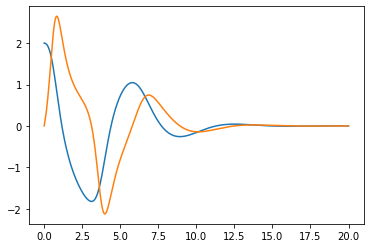

In [3]:
def vf(x, t):
    x1, x2 = x
    y = [-x2, x1 - (1-x1**2)*x2]
    return y

z0=[2,0]
t = np.linspace(0,20,501)
xx=odeint(vf, z0, t)
plt.figure(1)
plt.plot(t, xx[:,0],t,xx[:,1])
plt.show()


In [4]:
X = np.stack((xx[:,0], xx[:,1]), axis=-1)  # First column is x, second is y
model = ps.SINDy(feature_names=["x1", "x2"])
model.fit(X, t=t)
model.print()

(x1)' = -0.999 x2
(x2)' = 1.374 x1 + -0.291 x2 + 0.267 x1^2 + -0.134 x1 x2


In [15]:
# Generate measurement data
dt = .01

t_train = np.arange(0, 100, dt)
x0_train = [0, 2]
t_train_span = (t_train[0], t_train[-1])

# def vf(t, x):
#     x1, x2 = x
#     y = [-x2, x1 - (1-x1**2)*x2]
#     return y

# Van der Pol ODE
def van_der_pol(t, x, p=[1]):
    return [-x[1],  x[0] - p[0] * (1 - x[0] ** 2) * x[1]]


# def my_vf(t, x):
#     y = [-x[:,1], x[:,0] - (1-x[:,0]**2)*x[:,1]]
#     return y


x_train = solve_ivp(van_der_pol, t_train_span, x0_train,
                    t_eval=t_train, **integrator_keywords).y.T

# Instantiate and fit the SINDy model
lasso_optimizer = Lasso(alpha=0.001, max_iter=2000, fit_intercept=False)
diff_method = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
# opt = ps.optimizers.ssr.SSR()
opt = ps.optimizers.STLSQ(threshold=0.01, alpha = 0.1, max_iter=500, normalize_columns=True)
# x_dot = diff_method._differentiate(x_train, t_train)
funcs = [lambda x: x, lambda x: x**2, lambda x: x**3]
# lib = ps.feature_library.CustomLibrary(funcs).fit(x_train)
lib = ps.PolynomialLibrary(degree=3).fit(x_train)
lib.get_feature_names()
model = ps.SINDy(optimizer=opt, feature_library=lib, differentiation_method=diff_method ,feature_names=['x1', 'x2'])
model.fit(x_train, t=dt)
model.print()
model.score(x_train, dt)

(x1)' = -1.000 x2
(x2)' = 1.000 x1 + -1.000 x2 + 1.000 x1^2 x2


0.9999999991812458

In [16]:
# Evolve the Lorenz equations in time using a different initial condition
t_test = np.arange(0, 100, dt)
x0_test = np.array([0, 1.5])
t_test_span = (t_test[0], t_test[-1])
x_test = solve_ivp(van_der_pol, t_test_span, x0_test,
                   t_eval=t_test, **integrator_keywords).y.T
# Compare SINDy-predicted derivatives with finite difference derivatives
print('Model score: %f' % model.score(x_test, t=dt))

Model score: 1.000000


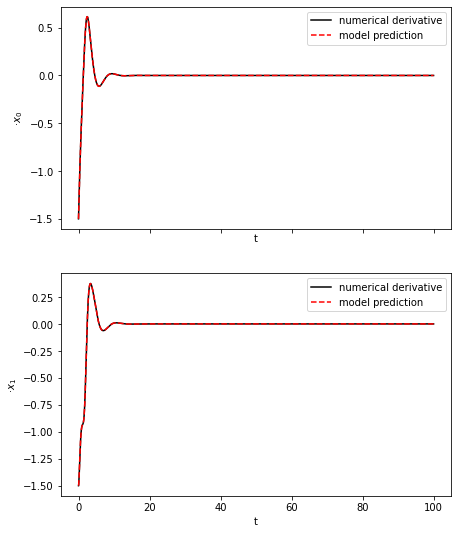

In [17]:
# Predict derivatives using the learned model
x_dot_test_predicted = model.predict(x_test)

# Compute derivatives with a finite difference method, for comparison
x_dot_test_computed = model.differentiate(x_test, t=dt)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_dot_test_computed[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_test, x_dot_test_predicted[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
# fig.show()


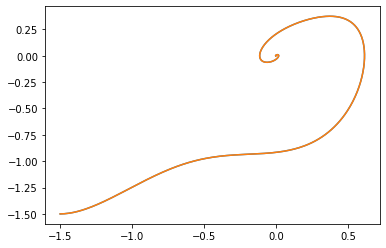

In [18]:
plt.plot(x_dot_test_computed[:,0], x_dot_test_computed[:,1])
plt.plot(x_dot_test_predicted[:,0], x_dot_test_predicted[:,1])

In [19]:
def my_vf(t, x):
    y = [-x[:,1], x[:,0] - (1-x[:,0]**2)*x[:,1]]
    return y
trial_x = np.array([[1.1,1.3]])
my_vf(np.random.normal(), trial_x)

[array([-1.3]), array([1.373])]

In [29]:
model.predict(trial_x).tolist()

[[-1.2999094579485697, 1.3726473140045414]]

In [31]:
import tensorflow as tf
tf.transpose(tf.convert_to_tensor(model.predict(trial_x), dtype=tf.float32))

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-1.2999095],
       [ 1.3726473]], dtype=float32)>

In [21]:
bounds = [1.6, 4]
numpoints = 20
# define plotting range and mesh
x = np.linspace(-bounds[0], bounds[0], numpoints)
y = np.linspace(-bounds[1], bounds[1], numpoints)

X, Y = np.meshgrid(x, y)

s = X.shape

Ze = np.zeros(s)
Zp = np.zeros(s)
DT = np.zeros((numpoints**2,2))

# convert mesh into point vector for which the model can be evaluated
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        DT[c,0] = X[i,j]
        DT[c,1] = Y[i,j]
        c = c+1;
vf_that_works =  np.array(my_vf(np.random.normal(), DT)).T
predicted = model.predict(DT)

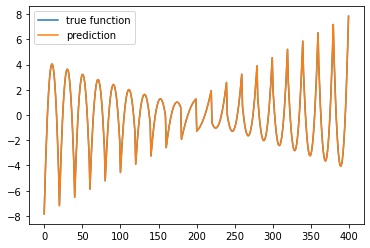

In [22]:
plt.plot(vf_that_works[:,1], label = 'true function')
plt.plot(predicted[:,1], label = 'prediction')
plt.legend()
plt.show()

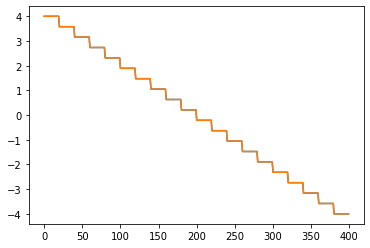

In [23]:
plt.plot(vf_that_works[:,0])
plt.plot(predicted[:,0])

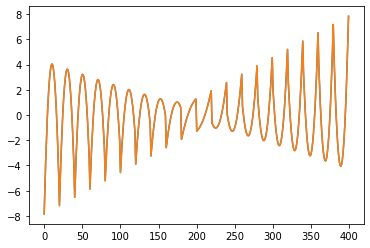

In [25]:
plt.plot(vf_that_works[:,1])
plt.plot(predicted[:,1])